In [11]:
#UNet demo for binary classification

imgs_path = '../data/train/imgs/'
masks_path = '../data/train/masks/'

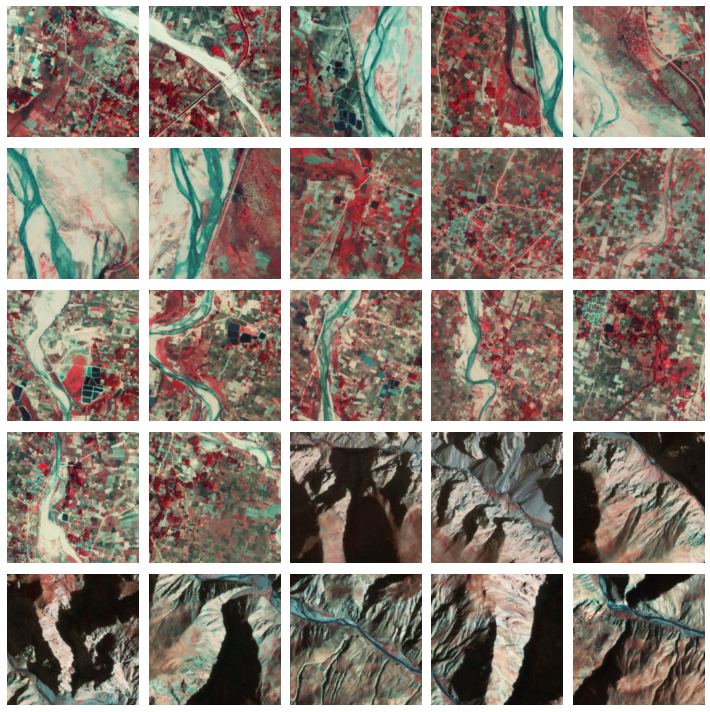

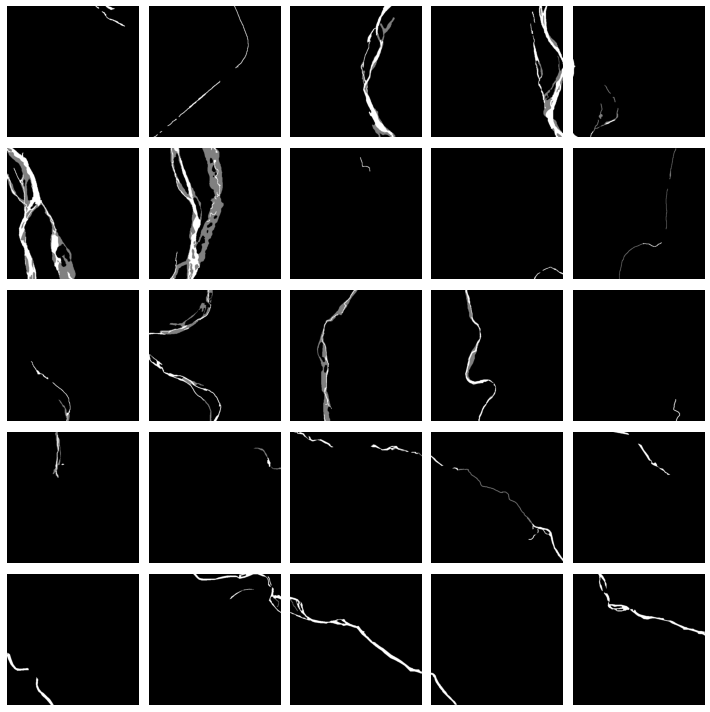

In [12]:
#check input imgs and masks
import os
import matplotlib.pyplot as plt
import cv2

class ImagePlotter:
    def __init__(self, input_folder):
        self.input_folder = input_folder

    def load_images_from_folder(self):
        images = []
        if "mask" not in self.input_folder.lower():
            for filename in os.listdir(self.input_folder)[-25:]:
                img = cv2.imread(os.path.join(self.input_folder, filename))
                images.append(img)
        else:
            for filename in os.listdir(self.input_folder)[-25:]:
                img = cv2.imread(os.path.join(self.input_folder, filename), cv2.IMREAD_GRAYSCALE)
                images.append(img)
        return images

    def plot_images(self):
        images = self.load_images_from_folder()
        fig, axs = plt.subplots(5, 5, figsize=(10, 10))
        for i in range(5):
            for j in range(5):
                idx = i * 5 + j
                if idx < len(images):
                    if "mask" not in self.input_folder.lower():
                        axs[i, j].imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
                    else:
                        axs[i, j].imshow(images[idx], cmap='gray')
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout()
        plt.show()

#Plot images
image_plotter = ImagePlotter(imgs_path)
image_plotter.plot_images()

#Plot masks
image_plotter = ImagePlotter(masks_path)
image_plotter.plot_images()

In [13]:
#Setup config and preprocess dataset for UNet

import os
import glob
import cv2
import time 
import rasterio
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sys import getsizeof

def prep_data(img_path,mask_path,val_split,random,kclass='multi'):
    start_prep = time.time()
    train_images = get_img_arrays(img_path)/255
    train_masks = get_img_arrays(mask_path,'*png',im_set='mask')
    if kclass == 'binary':
        train_masks[train_masks==2] = 1
        train_masks = train_masks[:,:,:,np.newaxis]
    elif kclass == 'multi':
        train_masks = get_img_arrays(mask_path,'*png',im_set='mask')
        train_masks = encode_masks(train_masks)
        
    X_train,X_test,y_train,y_test = train_test_split(train_images, train_masks, test_size = val_split, random_state = random)
    
    print('\timage shape: ',train_images.shape)
    print('\tmask shape: ',train_masks.shape)
    print(f'\n\tSplit - train: {len(y_train)}, val: {len(y_test)}, Seed: {random}')
    print(f"\n\ttrain_imgs size: {getsizeof(X_train)/1e6:.2f} MB")
    print(f"\ttrain_masks size: {getsizeof(y_train)/1e6:.2f} MB")
    print(f'\n\tPreprocessing time: {(time.time() - start_prep)/60:0.2f} min')
    
    return X_train, X_test, y_train, y_test


def get_img_arrays(imgs_fold_path,format_lookup='*tif',im_set='img'):
    img_list = sorted(glob.glob(imgs_fold_path+format_lookup))
    #images = [cv2.resize(cv2.imread(img_path,channel),dsize=size) for img_path in img_list]
    if im_set == 'mask':
        images = [cv2.imread(img_path,0) for img_path in img_list]
    elif im_set == 'img':
        images = []
        for img_path in img_list:
            with rasterio.open(img_path,'r') as f:
                imgr = np.moveaxis(f.read(),0,-1)
            images.append(imgr)
    return np.array(images).astype('float32')

def tf_dataset(x, y, cache, name, batch,w=""):
    #print(cache,name,batch,w)
    if len(w)>1:
        data = tf.data.Dataset.from_tensor_slices((x, y, w))
    else:
        w = None
        data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.batch(batch)
    data = data.take(len(x))
    
    #For caching
    #cache_path = f'./cache/{name}'
    #os.makedirs(cache_path,exist_ok=True)
    #data = data.cache(cache_path+f'/{name}_{cache}')
    #print('\n',data.element_spec)
    return data


#Main config
rand = 1  #tile selection random seed
k_class = 'binary' #binary or multi
batch_size = 16
mode = 'predict' #train or predict

#Log directory setup 
run_name = 'unet_test' 
log_folder = f'../log/{run_name}'
os.makedirs(log_folder,exist_ok=True)
modeln =  f'{run_name}_{rand}'  #log name with random seed index 

#check available gpus
gpus = tf.config.list_physical_devices('GPU')
print(len(gpus), "Physical GPUs,")

with tf.device('/CPU:0'): #use ram instead of gpu memory for data prep
    
    #Preprocess dataset to array, random splits, and multiclass to binary conversion
    X_train, X_test, y_train, y_test = prep_data(imgs_path,masks_path,0.3,rand,k_class)
    
    #transform to tfdataset, faster and optional cache (
    train_data = tf_dataset(X_train,y_train,'train',modeln,batch_size)
    val_data = tf_dataset(X_test,y_test,'val',modeln,batch_size)

4 Physical GPUs,
	image shape:  (450, 512, 512, 3)
	mask shape:  (450, 512, 512, 1)

	Split - train: 315, val: 135, Seed: 1

	train_imgs size: 990.90 MB
	train_masks size: 330.30 MB

	Preprocessing time: 0.14 min


In [14]:
#For monitoring/checkpoints of during model training

if k_class == 'binary':
    nclass = 1
    unet_monitor = 'val_binary_io_u'
if k_class == 'multi':
    nclass = 3
    unet_monitor = 'val_one_hot_mean_io_u'

logmonitor_file = f'{log_folder}/{modeln}.csv'
model_file = f'{log_folder}/{modeln}.hdf5'

mod_callbacks = [tf.keras.callbacks.CSVLogger(logmonitor_file, append=True), 
                 tf.keras.callbacks.ModelCheckpoint(model_file,verbose=1, 
                                 monitor=unet_monitor, mode='max', save_best_only=True)]

In [15]:
#training or prediction mode
import cv2
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.metrics import *


def unet(filter=18,kernel=3,input_size=(512,512,3),nclass=3):
    '''Build U-Net model'''
    #Contraction Path
    inputs = Input(input_size)
    c1,p1 = conv_block(filter,kernel,inputs,step=1)
    c2,p2 = conv_block(filter,kernel,p1,step=2)
    c3,p3 = conv_block(filter,kernel,p2,step=4)
    c4,p4 = conv_block_drop(filter,kernel,p3,step=8)
    
    #Bottom
    bottom = bottom_block(filter,kernel,p4,step=16)
    
    #Expansion Path
    uc1 = upconv_block(filter,kernel,bottom,c4,step=8)
    uc2 = upconv_block(filter,kernel,uc1,c3,step=4)
    uc3 = upconv_block(filter,kernel,uc2,c2,step=2)
    uc4 = upconv_block(filter,kernel,uc3,c1,step=1)
    
    #Final layer
    if nclass == 1:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    elif nclass > 1:
        activation = 'softmax'
        loss = 'categorical_crossentropy'
        
    uc4 = conv(nclass,kernel,step=2)(uc4)
    conv_out = Conv2D(nclass, 1, activation = activation)(uc4)
    
    #Compile model
    metrics = monitor_unet(nclass) 
    model = Model(inputs = inputs, outputs = conv_out)
    model.compile(optimizer = Adam(learning_rate = 1e-5), 
                      loss = loss, metrics = metrics)
    return model

def conv_block(filter,kernel,input,step=1):
    conv_step = conv(filter,kernel,step)(input)
    conv_step = conv(filter,kernel,step)(conv_step)
    p = MaxPooling2D(pool_size=(2, 2))(conv_step)
    return conv_step, p

def conv_block_drop(filter,kernel,input,step=1):
    conv_step = conv(filter,kernel,step)(input)
    conv_step = conv(filter,kernel,step)(conv_step)
    drop = Dropout(0.5)(conv_step)
    p = MaxPooling2D(pool_size=(2, 2))(drop)
    return drop, p

def upconv_block(filter,kernel,input,concat,step=1):
    upconv = conv(filter,2,step)(UpSampling2D(size=(2,2))(input))
    merge = concatenate([concat,upconv], axis=3)
    upconv = conv(filter,kernel,step)(merge)
    upconv = conv(filter,kernel,step)(upconv)
    return upconv
    
def bottom_block(filter,kernel,input,step):
    b = conv(filter,kernel,step)(input)
    b = conv(filter,kernel,step)(b)
    b = Dropout(0.5)(b) #Ronneberger et al.(2015), pp.239
    return b 

def conv(filter,kernel,step):
    return Conv2D(filter*step, kernel, activation='relu', 
                  kernel_initializer='he_normal', 
                  padding='same')

def monitor_unet(num_class):
    if num_class == 1:
        metrics = [
            BinaryAccuracy(name='acc'),
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc'),
            AUC(name='prc', curve='PR'), 
            BinaryIoU(target_class_ids=[1],threshold=0.20) 
        ]
    elif num_class > 1:
        metrics = ['acc', 
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc'),
            AUC(name='prc', curve='PR'), 
            OneHotMeanIoU(num_classes=num_class) 
        ]
    return metrics

if mode == 'train':    
    #Setup unet and train model
    tf.keras.backend.clear_session()
    #with tf.distribute.MirroredStrategy().scope():
    model = unet(input_size=(512,512,3),nclass=nclass)

    start_train = time.time()
    model.fit(train_data, verbose=1, epochs=500, 
              validation_data = val_data, callbacks=mod_callbacks)
    print(f'\nTraining time: {(time.time() - start_train)/60:0.2f} min')
    


In [16]:
if mode == 'predict':
    
    #For loading models
    tf.keras.backend.clear_session()
    model = load_model(model_file)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 18  504         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 18  2934        ['conv2d[0][0]']                 
                                )                                                             

Index(['epoch', 'acc', 'auc', 'binary_io_u', 'fn', 'fp', 'loss', 'prc',
       'precision', 'recall', 'tn', 'tp', 'val_acc', 'val_auc',
       'val_binary_io_u', 'val_fn', 'val_fp', 'val_loss', 'val_prc',
       'val_precision', 'val_recall', 'val_tn', 'val_tp'],
      dtype='object')


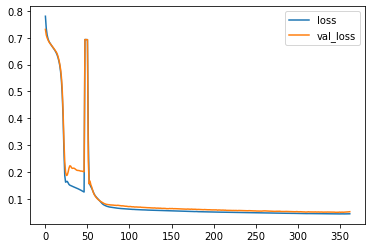

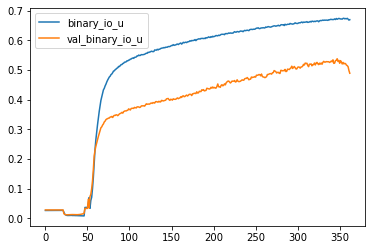

In [18]:
#check training logs
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv(logmonitor_file)
print(log.columns)
log.loss.plot()
log.val_loss.plot()
plt.legend()
plt.show()

log.binary_io_u.plot()
log.val_binary_io_u.plot()
plt.legend()
plt.show()

In [23]:
#predict a independent test set
import sklearn

def postprocess_cv(true,pred,kclass,model='multi'):

    if model == 'binary':
        pred = pred > 0.2 
        
    y_test,y_pred = pred_array(true,pred,kclass) 

    #for multi to binary test 
    #if m2b == True:
        #y_test, y_pred = multi_to_binary(y_test, y_pred)
 
    return y_test,y_pred
        
def pred_array(true,pred,kclass='multi'):
    if kclass == 'binary':
        true = true.reshape(-1)
        pred = pred.reshape(-1).astype('bool')
    elif kclass == 'multi':
        if true.shape[3] == 3:
            true = np.argmax(true,axis=3).reshape(-1)
        else:
            true.reshape(-1)
        pred = np.argmax(pred,axis=3).reshape(-1)
    return true, pred


def cm_score(true,pred,k_class):#,m2b=False):
    dict = {}
    cv_cm = sklearn.metrics.multilabel_confusion_matrix(true,pred)
    if k_class == 'binary':
        nclass = 2
    '''elif k_class == 'multi':
        if m2b == False:
            nclass = 3
        else:
            nclass = 2'''
    for i in range(nclass):
        dict[i] = cv_cm[i].ravel() # array: tn, fp, fn, tp
    return dict

def get_scores_df(cms):
    dict = {}
    for i in range(len(cms)):
        dict[i] = metrics(cms[i])
    df = pd.DataFrame(dict)
    df_means = pd.DataFrame(df.T.mean())
    df_means.columns = ['mean']
    df_out = pd.concat([df,df_means],axis=1).T
    return df_out

def metrics(cm_array):
    '''Classification metrics (Tharwat, 2018)'''
    dict = {}
    tn, fp, fn, tp = cm_array.ravel()
    precision = tp / (tp+fp)
    recall = tp / (tp + fn)
    specificity = tn / (fp + tn)
    dict['precision'] = precision
    dict['recall'] = recall
    dict['specificity'] = specificity
    dict['iou'] = tp/(tp + fn + fp)
    dict['f1'] = 2*(precision*recall)/(precision + recall)
    #dict['geom_mean'] = np.sqrt(recall * specificity)
    #dict['balanced_acc'] = (recall + specificity)/2
    return dict

with tf.device('/CPU:0'):
    #prep test set
    x_test_set = get_img_arrays('../data/test/imgs/')/255
    y_test_set = get_img_arrays('../data/test/masks/','*png',im_set='mask')
    y_test_set[y_test_set==2] = 1
    y_test_set = y_test_set[:,:,:,np.newaxis]
    print(f'Test set: {x_test_set.shape}, {y_test_set.shape}')
    
    y_pred = model.predict(x_test_set)
    
    y_test,y_pred_post = postprocess_cv(y_test_set,y_pred,k_class,model=k_class)

    #Get scores 
    cms = cm_score(y_test,y_pred_post,k_class)#,m2b=m2b) #confusion matrix
    scores = get_scores_df(cms)
    scores.to_csv(f'../log/{run_name}/metrics_{k_class}_{modeln}.csv')


Test set: (50, 512, 512, 3), (50, 512, 512, 1)
2/2 [==============================] - 8s 3s/step


In [24]:
print(scores)

      precision    recall  specificity       iou        f1
0      0.997147  0.977676     0.954780  0.974949  0.987316
1      0.725728  0.954780     0.977676  0.701613  0.824644
mean   0.861437  0.966228     0.966228  0.838281  0.905980


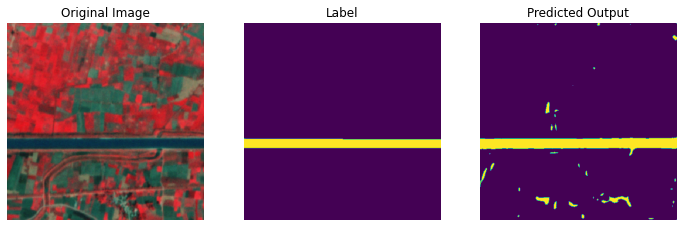

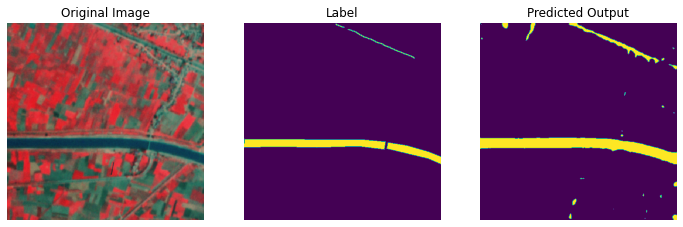

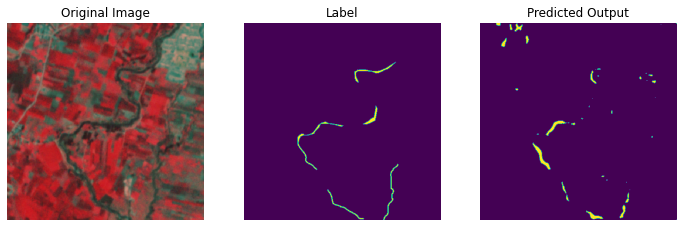

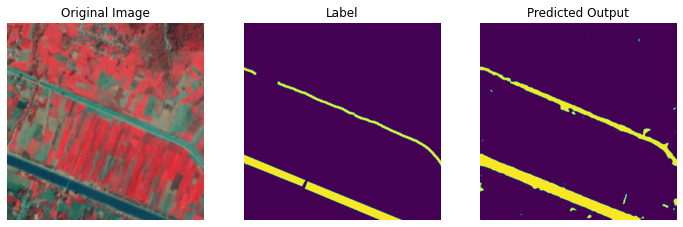

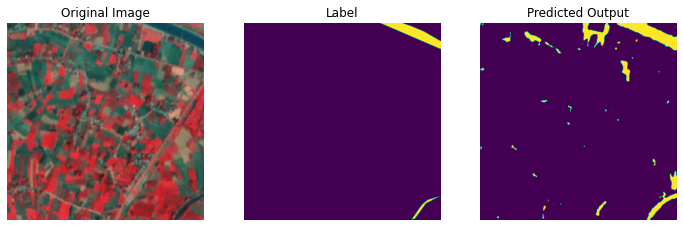

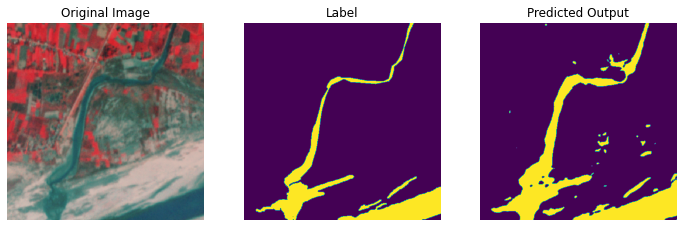

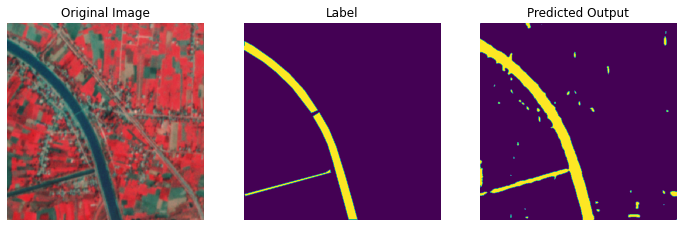

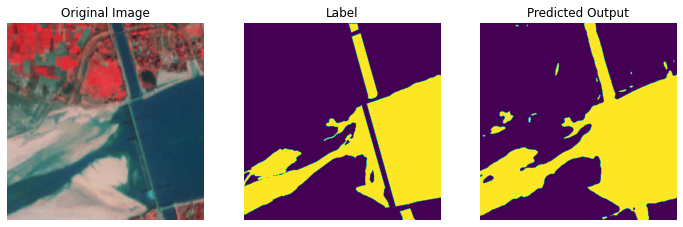

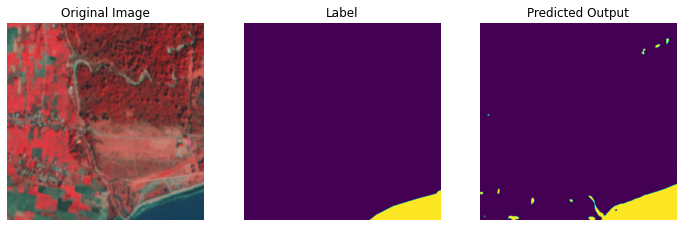

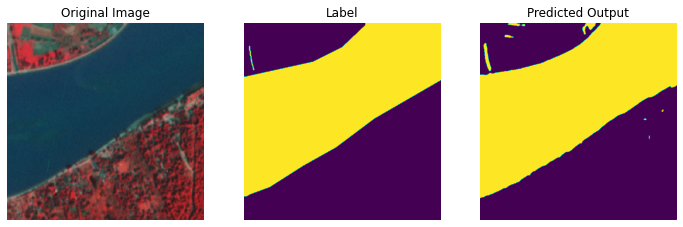

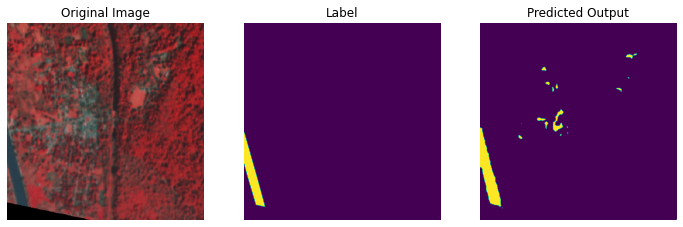

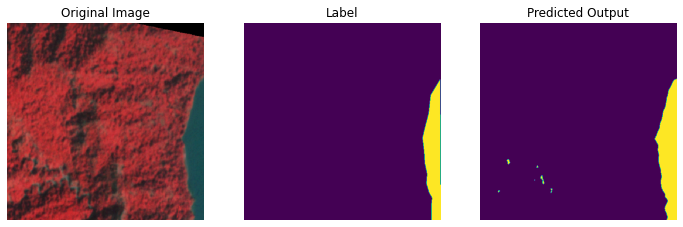

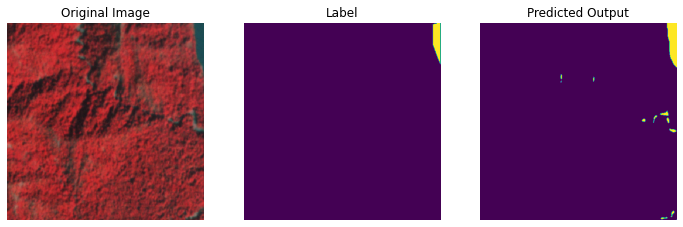

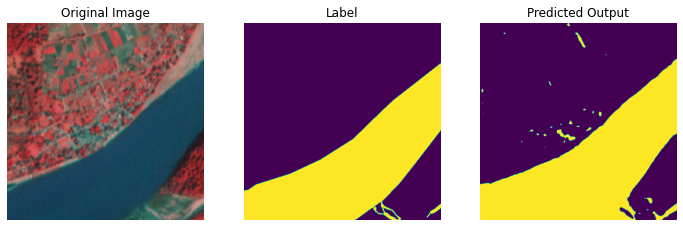

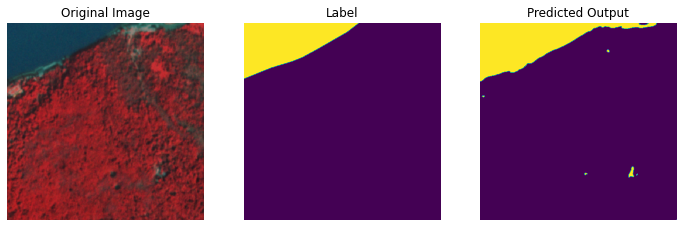

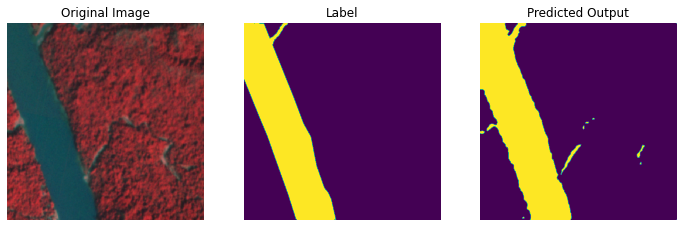

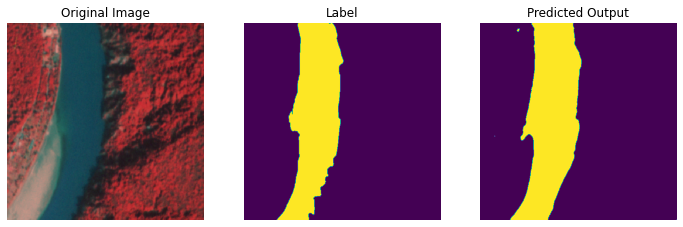

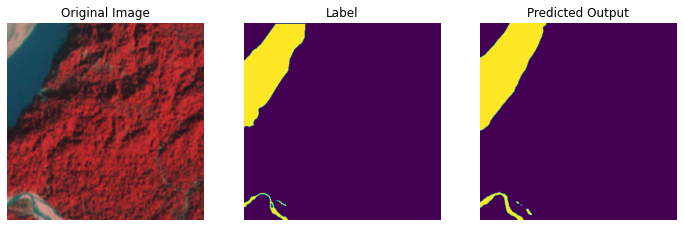

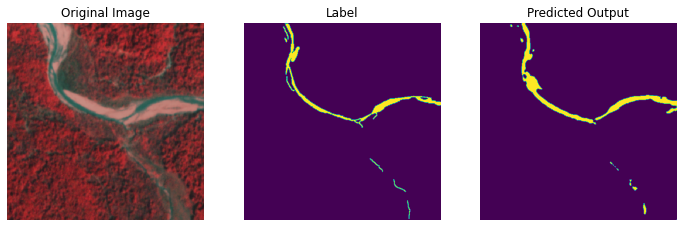

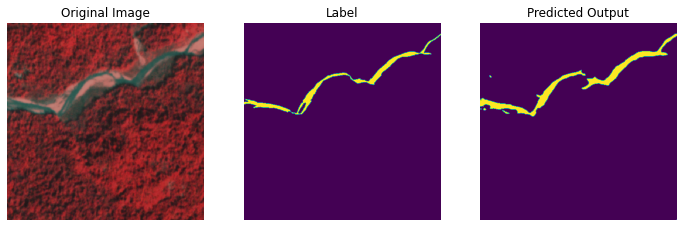

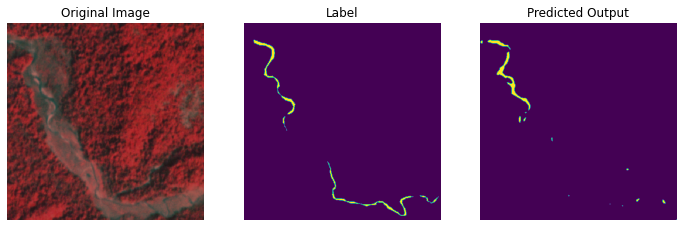

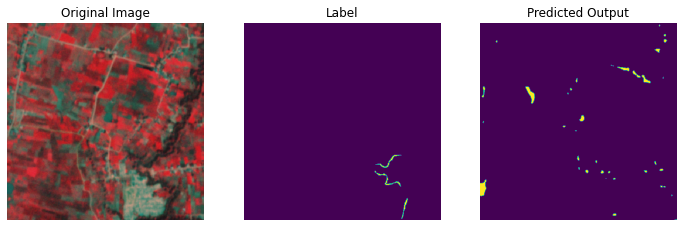

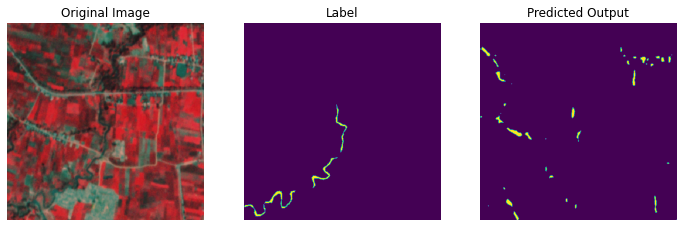

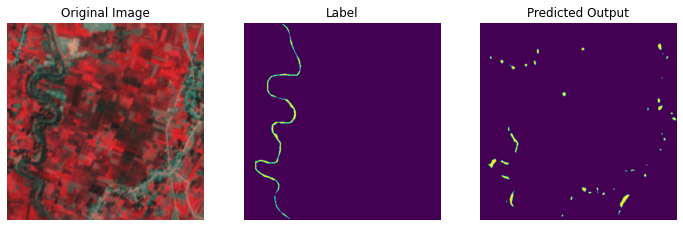

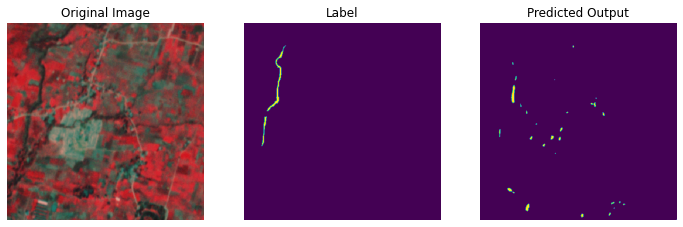

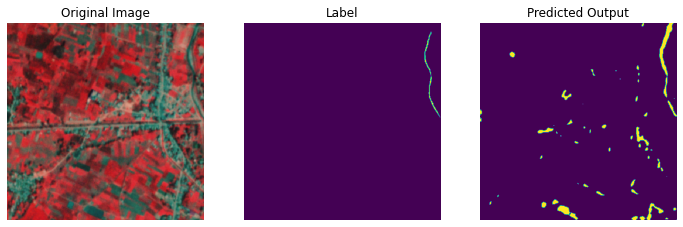

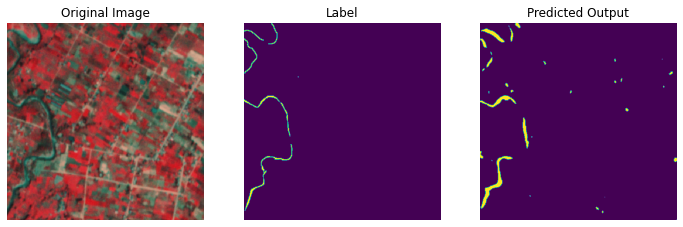

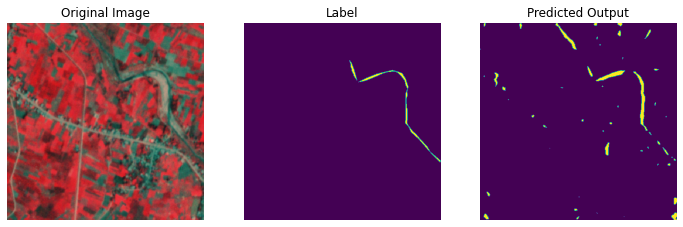

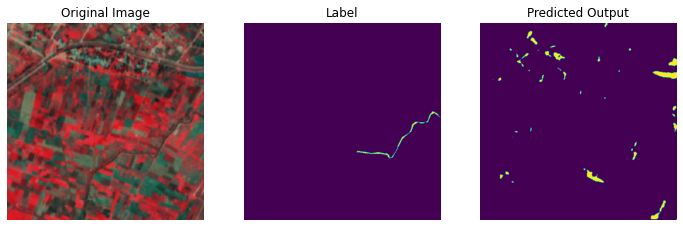

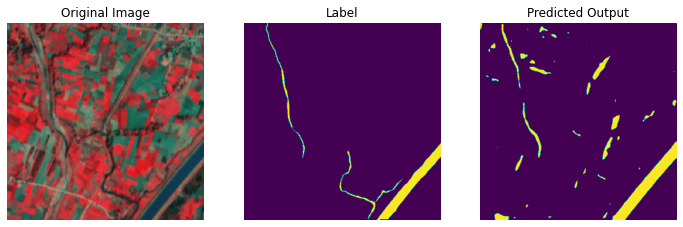

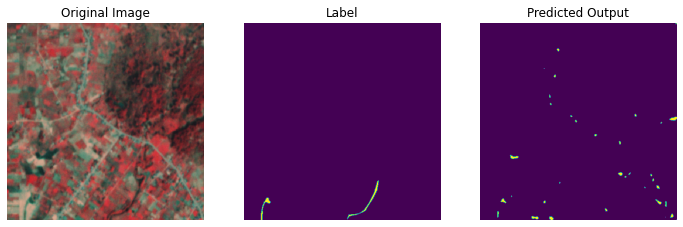

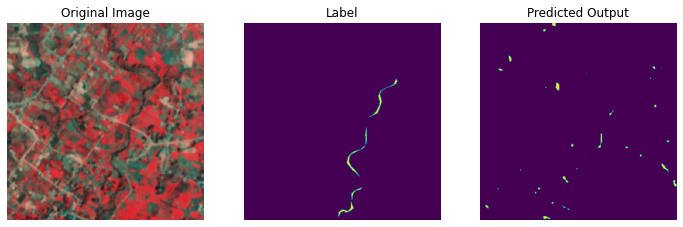

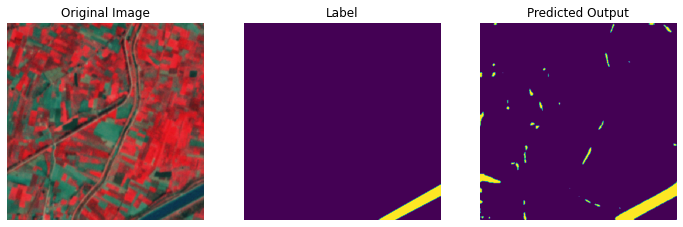

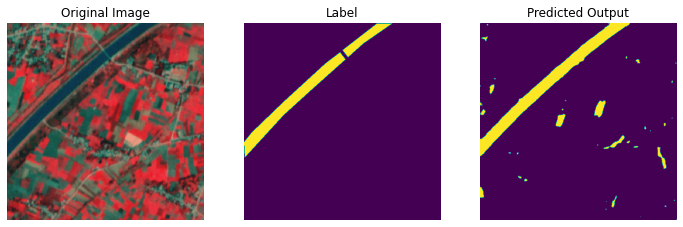

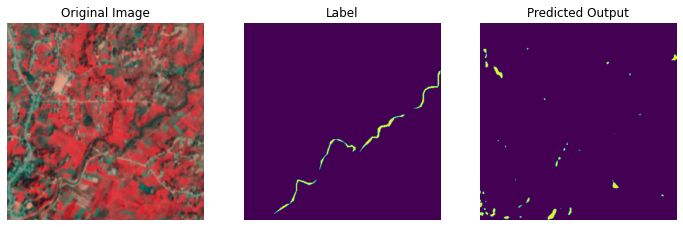

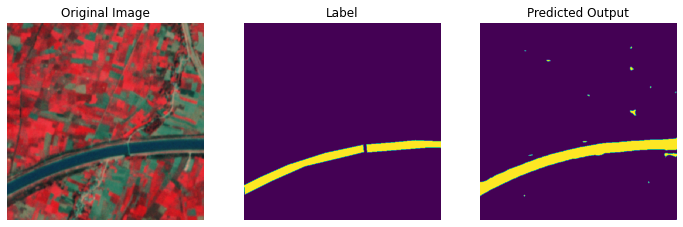

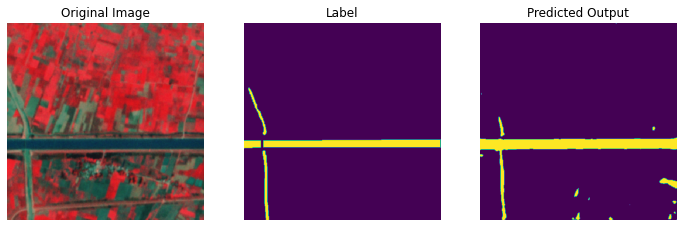

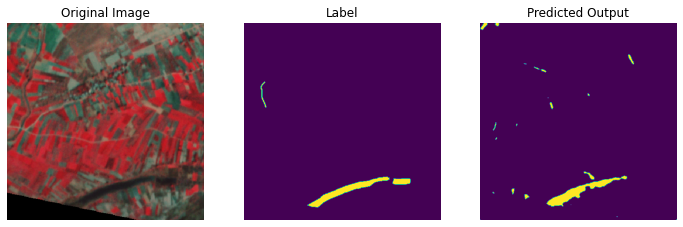

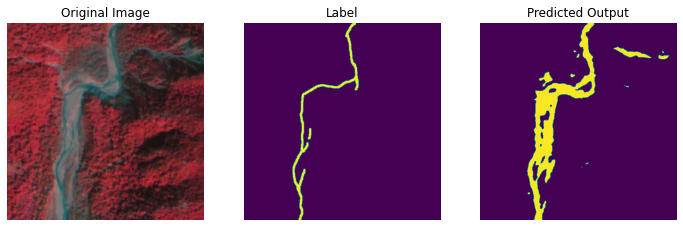

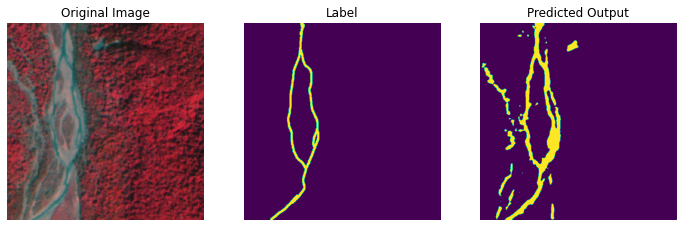

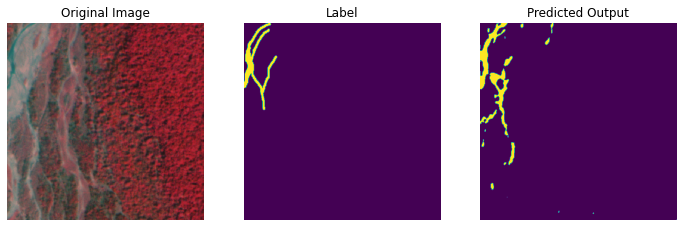

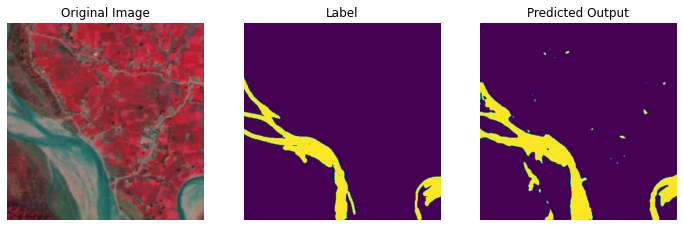

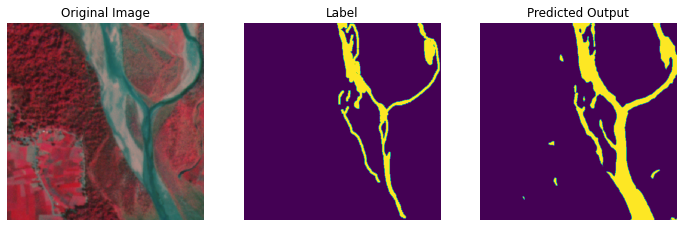

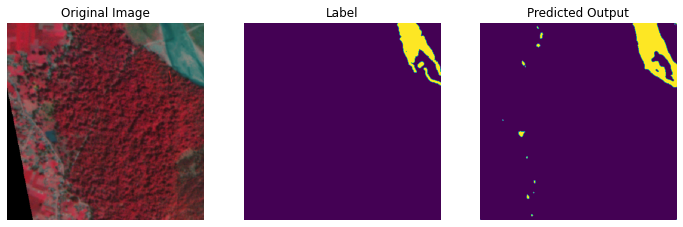

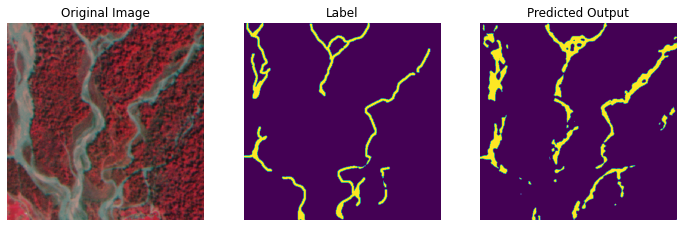

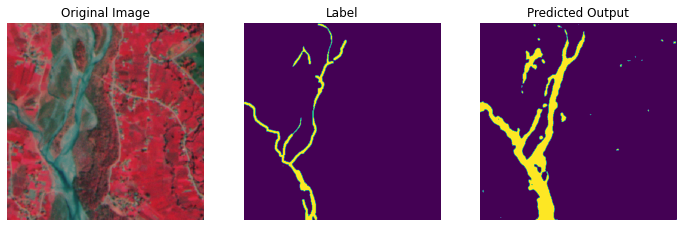

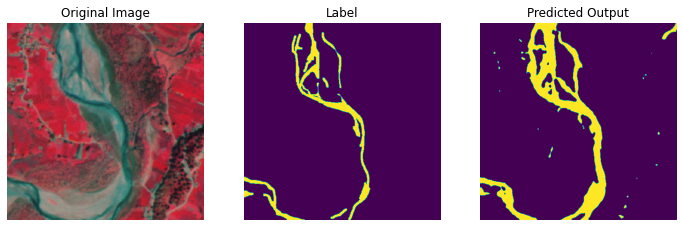

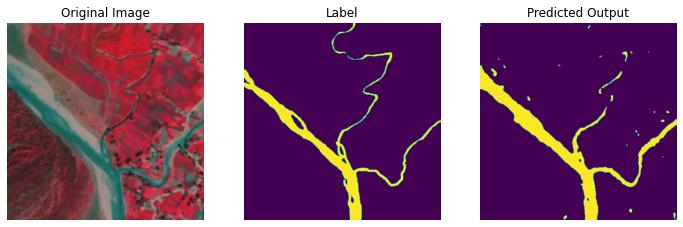

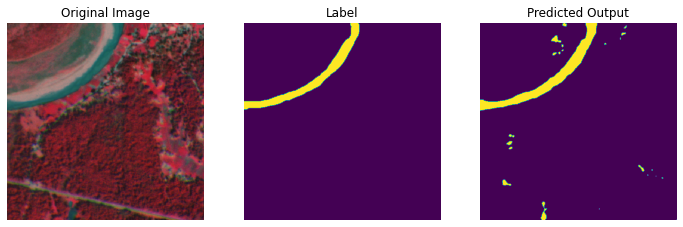

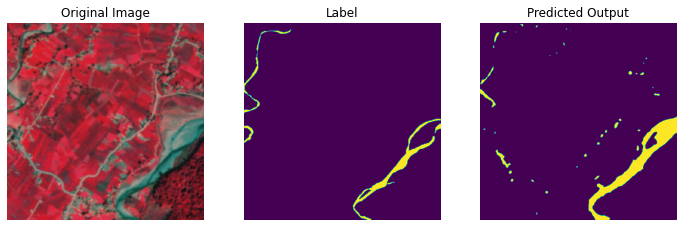

In [20]:
# Plot the predictions
for i in np.arange(50):
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))

    # Plot the original image
    axs[0].imshow(x_test_set[i])  
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Plot the labels
    axs[1].imshow(y_test_set[i])  
    axs[1].set_title('Label')
    axs[1].axis('off')
    
    # Plot the predicted output
    #print(y_pred[i].mean())
    axs[2].imshow(y_pred[i]>0.2) 
    axs[2].set_title('Predicted Output')
    axs[2].axis('off')

    plt.show()